In [1]:
import traffic
import pandas as pd 
from biblio_herramienta.herramienta import *
from biblio_herramienta.tratardatos import *

In [2]:
carpetaDatos = r'datos_sectores/' # carpeta que contiene los datos
nombreDatos = "datos_bilbao.csv"  # nombre del archivo

## 1. Carga de los datos descargados del sector de Bilbao
Las siguientes celdas muestran el proceso de carga de los datos en una variable del entorno

In [3]:
vuelos = cargardatos(carpetaDatos,nombreDatos)

In [4]:
vuelos.data.head()

,Unnamed: 0,alert,altitude,callsign,geoaltitude,groundspeed,hour,icao24,last_position,latitude,longitude,onground,spi,squawk,timestamp,track,vertical_rate
0,0,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:19.800000+00:00,42.334791,-3.236176,False,False,5337.0,2019-02-05 02:10:20+00:00,11.654737,0.0
1,1,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:20.831000064+00:00,42.336467,-3.235665,False,False,5337.0,2019-02-05 02:10:21+00:00,11.654737,0.0
2,2,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:20.831000064+00:00,42.336467,-3.235665,False,False,5337.0,2019-02-05 02:10:22+00:00,11.654737,0.0
3,3,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:22.258999808+00:00,42.338376,-3.235154,False,False,5337.0,2019-02-05 02:10:23+00:00,11.654737,0.0
4,4,False,36000.0,FPO1364,NaN,391.0,2019-02-05 02:00:00+00:00,396668,2019-02-05 02:10:22.258999808+00:00,42.338376,-3.235154,False,False,5337.0,2019-02-05 02:10:24+00:00,11.654737,0.0


In [5]:
vuelos.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111087 entries, 0 to 2111086
Data columns (total 17 columns):
 #   Column         Dtype              
---  ------         -----              
 0   Unnamed: 0     int64              
 1   alert          bool               
 2   altitude       float64            
 3   callsign       object             
 4   geoaltitude    float64            
 5   groundspeed    float64            
 6   hour           datetime64[ns, UTC]
 7   icao24         object             
 8   last_position  datetime64[ns, UTC]
 9   latitude       float64            
 10  longitude      float64            
 11  onground       bool               
 12  spi            bool               
 13  squawk         float64            
 14  timestamp      datetime64[ns, UTC]
 15  track          float64            
 16  vertical_rate  float64            
dtypes: bool(3), datetime64[ns, UTC](3), float64(8), int64(1), object(2)
memory usage: 231.5+ MB


In [6]:
vuelos_prueba = vuelos.data.copy() 
vuelos_prueba = traffic.core.Traffic(vuelos_prueba)# generamos otros df de vuelos para poder editarlo sin perder los datos originales

# 2. Filtrado de los datos bajo las condiciones del sector
Como se ha explicado, los datos deben filtrarse bajo ciertas condicones para asegurar que son los que se buscan para generar las base de datos. Las condiciones del sector elegido implica que:
1. Las aeronaves no pueden estar en tierra
2. Las aeronaves deben estar sobre el FL 345


In [7]:
# elimina las aeronaves en tierra
aviones_entierra =  vuelos_prueba.data[vuelos_prueba.data["onground"] == True].index # elimina las aeronaves en tierra
vuelos_prueba.data.drop(aviones_entierra,inplace = True)

In [8]:
# elimina las aeronaves que está debajo del FL 345
aviones_debajosector = vuelos_prueba.data[vuelos_prueba.data["altitude"] <= 34500].index
vuelos_prueba.data.drop(aviones_debajosector,inplace = True)

## 2.1 Comprobación de los datos
A continuación, se puede ver los datos contenidos tras filtrarlos, y el número de aeronaves en el sector

In [9]:
vuelos_prueba.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1435098 entries, 0 to 2110882
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   Unnamed: 0     1435098 non-null  int64              
 1   alert          1435098 non-null  bool               
 2   altitude       1431842 non-null  float64            
 3   callsign       1425129 non-null  object             
 4   geoaltitude    1380259 non-null  float64            
 5   groundspeed    1426365 non-null  float64            
 6   hour           1435098 non-null  datetime64[ns, UTC]
 7   icao24         1435098 non-null  object             
 8   last_position  1435098 non-null  datetime64[ns, UTC]
 9   latitude       1435098 non-null  float64            
 10  longitude      1435098 non-null  float64            
 11  onground       1435098 non-null  bool               
 12  spi            1435098 non-null  bool               
 13  squawk      

In [10]:
# Esto muestra el número de aeroanves dentro del sector que cumplen las condciones enunciadas
vuelos_prueba.data["callsign"].nunique()

1507

In [11]:
vuelos_prueba

,,count
icao24,callsign,
4ca60f,IBK5BV,4035
4cace5,IBK6054,3268
396668,FPO1364,3259
344495,GES381L,3217
396668,FPO1363,3092
49514c,TAP434M,3068
4cace5,IBK6055,2691
345645,VLG3981,2480
48520d,TRA845,2193


## 3. Limpieza de vuelos no validos
Hay muchos datos que están incompletos o no son validos. OpenSky incorpora funciones para poder limpiar los datos descargados

In [12]:
vuelos_prueba = vuelos_prueba.clean_invalid()
vuelos_prueba = vuelos_prueba.drop_duplicates()
vuelos_prueba

,,count
icao24,callsign,
4ca60f,IBK5BV,4035
4cace5,IBK6054,3268
396668,FPO1364,3259
344495,GES381L,3217
396668,FPO1363,3092
49514c,TAP434M,3068
4cace5,IBK6055,2691
345645,VLG3981,2480
48520d,TRA845,2193


In [13]:
vuelos_bien = vuelos_prueba.data.copy()
vuelos_bien = traffic.core.Traffic(vuelos_bien)

## 4. Rellenar y eliminar datos corruptos o que tienen un número de muestras disitntos al resto
Lo que se va a realizar a continuación es:  
* Eliminar los datos que tinen más de 10 datos ccorruptos
* Rellenar todos los huecos que se encuentren entre valores con la media entre los dos datos siguientes
* Elimnar todas aquellas filas que contienen datos Nan ( Not a number)

In [14]:
# Variables que tienen huecos:
Var_huecos = vuelos_prueba.data.columns[vuelos_prueba.data.isnull().any()]
# Identificar las filas que tienen Nan:
nan_rows = vuelos_prueba.data[vuelos_prueba.data.isnull().any(1)]

# Identificar las aeronaves que tienen problemas con esto:
ave_huecos = nan_rows.callsign.value_counts()
list_ave = []
# se identifican las aeronaves que tienen más de 10 datos ads-b con fallos
v_filtrado = vuelos_prueba
for count, values in enumerate(ave_huecos):
    if values > 10:
        list_ave.append(ave_huecos.index[count])
        # se identifican las filas de las aeronaves y las eliminamos
        rows = vuelos_prueba.data.loc[vuelos_prueba.data.callsign == ave_huecos.index[count]].index
        v_filtrado = v_filtrado.drop(rows)

# Eliminamos todas las filas que tienen NaN
v_filtrado = v_filtrado.data.dropna()
v_filtrado = traffic.core.Traffic(v_filtrado)

In [15]:
v_filtrado

,,count
icao24,callsign,
4ca60f,IBK5BV,4034
4cace5,IBK6054,3266
344495,GES381L,3216
49514c,TAP434M,3065
4cace5,IBK6055,2689
345645,VLG3981,2478
48520d,TRA845,2193
4ca25a,RYR5VC,2183
3c56f7,EWG4TP,2171


In [16]:
import numpy as np
# Vamos a rellenar los huecos que faltan con la introducción del valor medio. 
# Variables que tienen huecos:
Var_huecos = []
# Detectar las aeronaves que tienen huecos
aves_huecos = []

# Construimos el método impute con las características que queremos para rellenar las celdas
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#Aplicamos el método a cada aeronave:
for count, name in enumerate(aves_huecos):
    ave_impute = pd.DataFrame(my_imputer.fit_transform(vuelos_prueba))


# Se comprueba que el resultado es la introducción de estos valores
v_filtrado.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247356 entries, 125 to 2107486
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   Unnamed: 0     1247356 non-null  int64              
 1   alert          1247356 non-null  bool               
 2   altitude       1247356 non-null  float64            
 3   callsign       1247356 non-null  object             
 4   geoaltitude    1247356 non-null  float64            
 5   groundspeed    1247356 non-null  float64            
 6   hour           1247356 non-null  datetime64[ns, UTC]
 7   icao24         1247356 non-null  object             
 8   last_position  1247356 non-null  datetime64[ns, UTC]
 9   latitude       1247356 non-null  float64            
 10  longitude      1247356 non-null  float64            
 11  onground       1247356 non-null  bool               
 12  spi            1247356 non-null  bool               
 13  squawk    

In [17]:
v_filtrado
guardarcsv(v_filtrado,"datos_filtrados_def",carpetaDatos)

In [18]:
v_filtrado.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247356 entries, 125 to 2107486
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   Unnamed: 0     1247356 non-null  int64              
 1   alert          1247356 non-null  bool               
 2   altitude       1247356 non-null  float64            
 3   callsign       1247356 non-null  object             
 4   geoaltitude    1247356 non-null  float64            
 5   groundspeed    1247356 non-null  float64            
 6   hour           1247356 non-null  datetime64[ns, UTC]
 7   icao24         1247356 non-null  object             
 8   last_position  1247356 non-null  datetime64[ns, UTC]
 9   latitude       1247356 non-null  float64            
 10  longitude      1247356 non-null  float64            
 11  onground       1247356 non-null  bool               
 12  spi            1247356 non-null  bool               
 13  squawk    

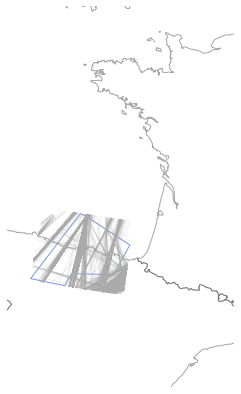

In [20]:
representarSobreSector(v_filtrado)
guardarimagen('filtrado_datos','trayec_filtradas.png')

Todo este proceso se ha resumido en una sola función llamada: ```filtrardatos(datos)``` contenida dentro de << biblio_herramienta.herramienta >>